In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
import random
from tensorflow import keras
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, BatchNormalization, Softmax
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
import datetime
from time import time
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers.pooling import GlobalAveragePooling2D

import sys
sys.path.append("/home/ecbm4040/Final_Project/e4040-2021Fall-Project-SCNN-as6430-as6456-vsk2123/src/")

In [4]:
# Load and prepare data

# CIFAR10 Dataset
from modules.utils import load_data
X_train, y_train = load_data(mode='train')
num_training = 49000
num_validation = 1000

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data, and reshape it to be RGB size
mean_image = np.mean(X_train, axis=0)
X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image

X_train = X_train.reshape(-1,3,32,32).transpose(0,2,3,1) / 255
X_val = X_val.reshape(-1,3,32,32).transpose(0,2,3,1) / 255

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

y_train_dummy = tf.keras.utils.to_categorical(y_train)
y_val_dummy = tf.keras.utils.to_categorical(y_val)
print('Train labels shape (one-hot): ', y_train_dummy.shape)
print('Validation labels shape (one-hot): ', y_val_dummy.shape)


Start downloading data...
Download complete.
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Train labels shape (one-hot):  (49000, 10)
Validation labels shape (one-hot):  (1000, 10)


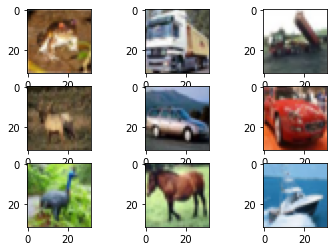

In [ ]:
# Plot sample images before augmentation
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

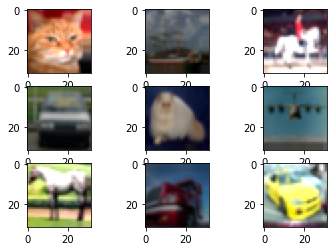

In [ ]:
# Data augmentation code

def HSV_perturbations(image):
    """
    Takes an input image and returns it with either the randomly adjusted hue or saturation
    (or may be makes no HSV change at all) with a probability of 1/3
    """
    choice=random.randint(1,3)
    print(choice)
    image = np.array(image)
    if choice ==1:
        return tf.image.random_hue(image, 1/random.randint(1,10))
    elif choice ==2:
        return tf.image.random_saturation(image, 5, 10)
    else:
        return image # so as to avoid not change hue for every image

datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
    )
datagen.fit(x_train)

# Plot sample augmented images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [ ]:
# Define CNN model architecture
def spatialCNN():

    model = Sequential()

    model.add(Conv2D(96, kernel_size=(3,3),padding="same", input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

    model.add(Conv2D(192, kernel_size=(3,3),padding="same"))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dense(512))
    model.add(Dense(output_size, activation='softmax')) 
    

    return model
    


In [ ]:
# Compiling and training the model
batch_size=128
nb_epochs=50

train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
valid_generator = datagen.flow(x_test, y_test, batch_size=batch_size)

standard_cnn_model = spatialCNN()
print(standard_cnn_model.summary())
standard_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#history=standard_cnn_model.fit(x=x_train, y=y_train, batch_size=batch_size,epochs=nb_epochs, validation_data=(x_test, y_test))
history=standard_cnn_model.fit_generator(train_generator,epochs=nb_epochs,steps_per_epoch=len(x_train)//batch_size, validation_data=valid_generator)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 96)        2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 192)       166080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 192)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9408)              0         
                                                                 
 dense (Dense)               (None, 1024)              9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 71s 149ms/step - loss: 106.0092 - accuracy: 0.4201 - val_loss: 3.5405 - val_accuracy: 0.4967
Epoch 2/50
390/390 [==============================] - 59s 151ms/step - loss: 2.3148 - accuracy: 0.5287 - val_loss: 1.7582 - val_accuracy: 0.5573
Epoch 3/50
390/390 [==============================] - 58s 148ms/step - loss: 1.4460 - accuracy: 0.5797 - val_loss: 1.3302 - val_accuracy: 0.5860
Epoch 4/50
390/390 [==============================] - 58s 149ms/step - loss: 1.2299 - accuracy: 0.6076 - val_loss: 1.1987 - val_accuracy: 0.6056
Epoch 5/50
390/390 [==============================] - 58s 149ms/step - loss: 1.1622 - accuracy: 0.6182 - val_loss: 1.1586 - val_accuracy: 0.6188
Epoch 6/50
390/390 [==============================] - 59s 151ms/step - loss: 1.1466 - accuracy: 0.6236 - val_loss: 1.1553 - val_accuracy: 0.6203
Epoch 7/50
390/390 [==============================] - 58s 150ms/step - loss: 1.1388 - accuracy: 0.6257 - val_loss: 1.2054 - val_

In [ ]:
# Save the model
standard_cnn_model.save('spatialCNNGenericCIFAR10.h5') # Save model

# Save the history so as to make the plot
import pickle
with open('historyspatialCNNGenericCIFAR10', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)